In [1]:
import numpy as np
from time import sleep

In [2]:
import tables

In [3]:
import pandas as pd

In [4]:
from scipy.interpolate import interp1d

In [5]:
from astropy.cosmology import FlatLambdaCDM, Planck18

In [6]:
import vrpy_tools

In [7]:
import matplotlib.pyplot as plt

In [8]:
L=150
i=100
rund='r1'

In [9]:
siminfo = vrpy_tools.ReadSimInfo(f"/scratch/cprem/sims/bdm_cdm1024/{rund:s}/halos_vr_6d/out_{i:03d}")

In [10]:
config = vrpy_tools.ReadConfigInfo(f"/scratch/cprem/sims/bdm_cdm1024/{rund:s}/halos_vr_6d/out_{i:03d}")

In [11]:
# config

In [12]:
a = siminfo['ScaleFactor']
z = 1/a - 1
h = siminfo['h_val']
Om_m = siminfo['Omega_m']

In [13]:
p18py = Planck18

In [14]:
a

0.538462

In [15]:
vir_dens = config['Virial_density']*config['Critical_density']/p18py.Om(z)

In [16]:
# vir_dens *= h**2 / a**3; vir_dens

In [17]:
vir_dens/config['Virial_density']

338527355661.23816

In [18]:
# siminfo

In [19]:
halprop = tables.open_file(f"/scratch/cprem/sims/bdm_cdm1024/{rund:s}/halos_vr_6d/out_{i:03d}.properties.0", 'r')

In [20]:
halprop.root.Mass_200mean

/Mass_200mean (Array(1484193,)) ''
  atom := Float64Atom(shape=(), dflt=0.0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := None

In [21]:
halprop.root.hostHaloID

/hostHaloID (Array(1484193,)) ''
  atom := Int64Atom(shape=(), dflt=0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := None

In [22]:
kin_ratio = 2*halprop.root.Ekin[:] /np.abs(halprop.root.Epot[:]); print(kin_ratio<1.5)

[ True False  True ...  True  True False]


In [23]:
radprof = tables.open_file(f"/scratch/cprem/sims/bdm_cdm1024/{rund:s}/halos_vr_6d/out_{i:03d}.profiles.0", 'r')

In [24]:
radprof.root.Mass_profile

/Mass_profile (Array(1484193, 20)) ''
  atom := Float32Atom(shape=(), dflt=0.0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := None

In [25]:
# select_mass_ind = np.where(np.logical_and(halvirmass>5e1, halvirmass<6e1))

In [26]:
massbins = 10**np.arange(1,4.1,0.5)*1e10
halvirmass = halprop.root.Mass_BN98[:]

In [27]:
radbins = np.logspace(-1.3,-0.3,10)
halvirrad = halprop.root.R_BN98[:]

In [28]:
# j=10

In [29]:
# np.where(np.logical_and(halvirmass>massbins[j], halvirmass<massbins[j+1], halprop.root.hostHaloID[:]==-1))

In [30]:
# radprof.root.Mass_profile[:,0][select_mass_ind[0]]

In [31]:
Rad_bin_edge = radprof.root.Radial_bin_edges[:]

In [32]:
Rad_bin_cen = (Rad_bin_edge[1:] + Rad_bin_edge[:-1])/ 2

In [33]:
Rad_bin_cen

array([0.005     , 0.01168617, 0.01562714, 0.02089714, 0.02794437,
       0.03736816, 0.04996996, 0.06682153, 0.08935601, 0.11948988,
       0.15978592, 0.21367114, 0.28572828, 0.38208555, 0.51093773,
       0.68324323, 0.91365599, 1.22177175, 1.63379455, 2.18476541])

100000000000.0 316227766016.83795 5000
0.1313100462017717


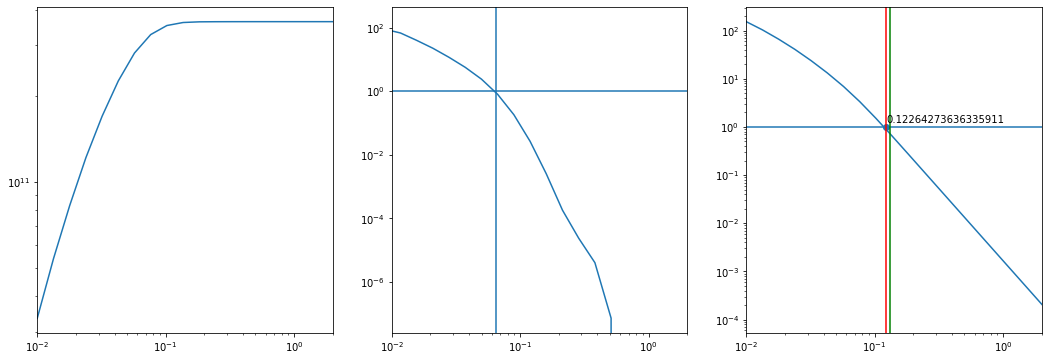

5000
316227766016.83795 1000000000000.0 5000
0.19141222311235082


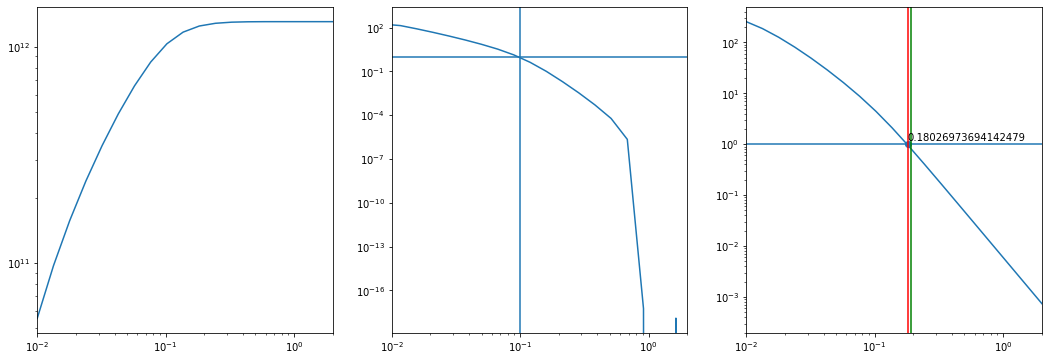

5000
1000000000000.0 3162277660168.3794 5000
0.2798041169833755


/mnt/home/student/cprem/anaconda3/envs/conforg/lib/python3.9/site-packages/numpy/core/_methods.py:160: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
<ipython-input-42-90dea69ccc29>:10: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax1.set_xlim(1e-2,2)
<ipython-input-42-90dea69ccc29>:20: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax3.axhline(1)


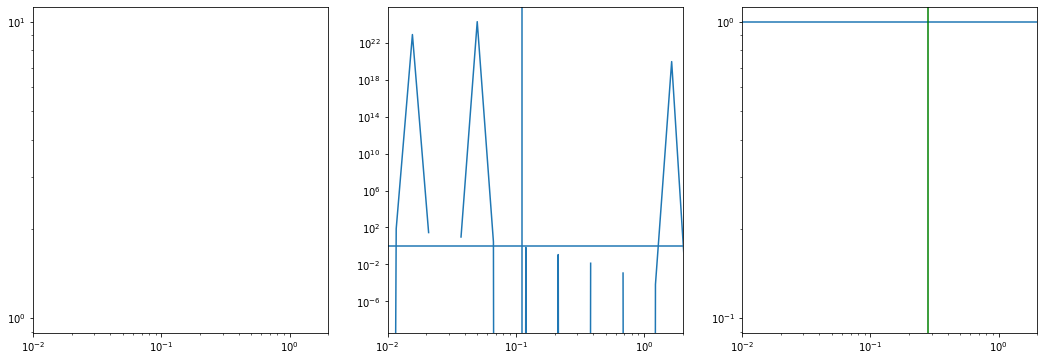

5000
3162277660168.3794 10000000000000.0 4746
0.407211746639328


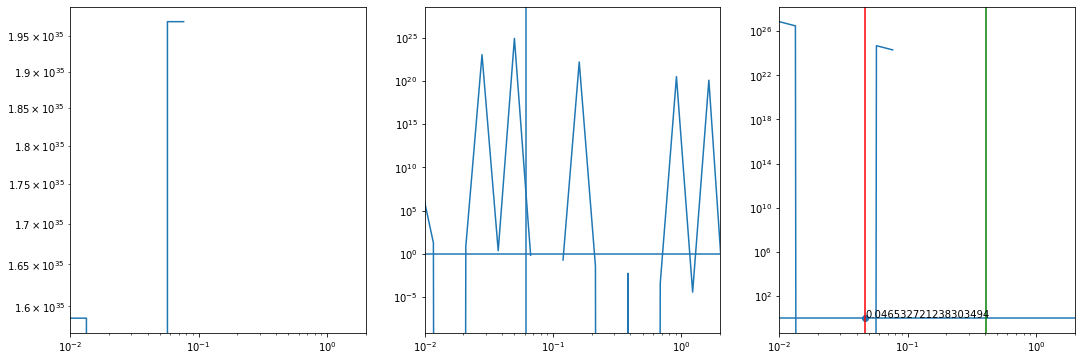

4746
10000000000000.0 31622776601683.797 1071
0.5958528986264545


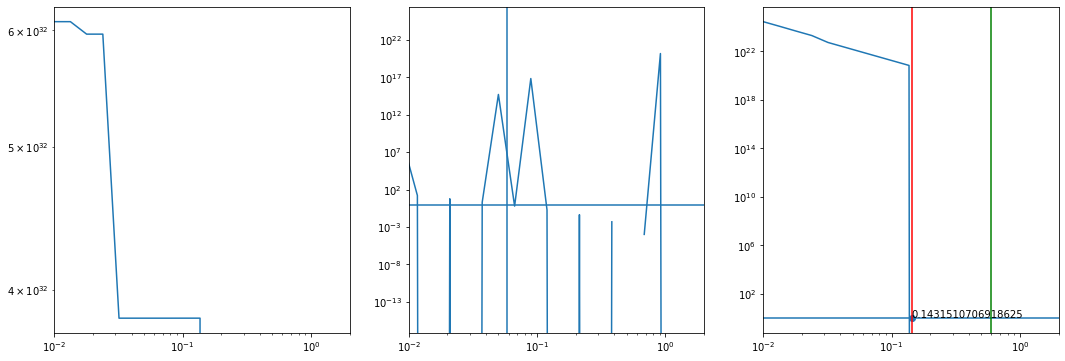

1071
31622776601683.797 100000000000000.0 199
0.8627336765067047
noisy data


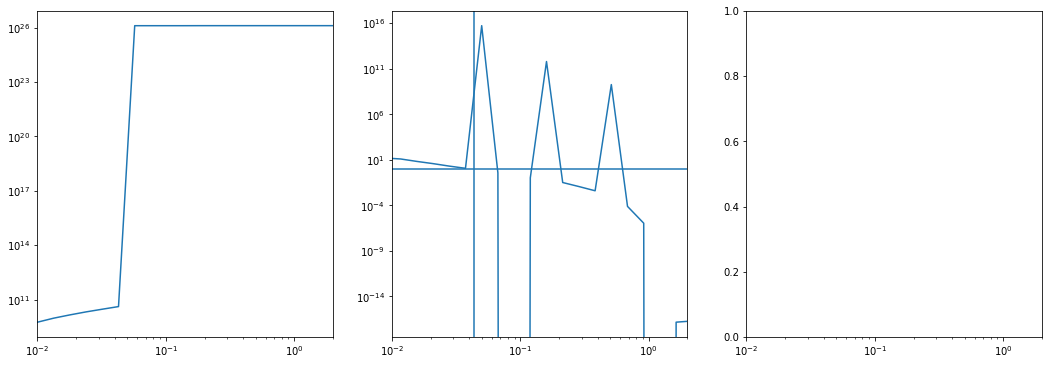

In [42]:
for j in range(len(massbins)-1):
    try:
        select_mass_ind = np.where(np.all((halvirmass>massbins[j], halvirmass<massbins[j+1], halprop.root.hostHaloID[:]==-1, abs(kin_ratio-1) < 0.5), axis=0))[0][:5000]
        print(massbins[j], massbins[j+1], len(select_mass_ind))
        mass_profile_mean = radprof.root.Mass_profile[:][select_mass_ind].mean(axis=0)*h**2/a**3
        r_vir_vr_mean = halprop.root.R_BN98[:][select_mass_ind].mean(axis=0)
        print(r_vir_vr_mean)
        fig, (ax1,ax2, ax3) = plt.subplots(1,3, figsize=(18,6), sharex=True)
        ax1.loglog(Rad_bin_edge[1:], np.cumsum(mass_profile_mean))
        ax1.set_xlim(1e-2,2)
        rhor = mass_profile_mean/ (4/3*np.pi* (Rad_bin_edge[1:]**3-Rad_bin_edge[:-1]**3) )/ vir_dens
        r_rho_is_vir = interp1d(rhor, Rad_bin_cen)(1)
        ax2.loglog(Rad_bin_cen, rhor,)
        ax2.axhline(1)
        ax2.axvline(r_rho_is_vir)
        rhoR = np.cumsum(mass_profile_mean)/ (4/3*np.pi* (Rad_bin_edge[1:]**3))/ vir_dens
        r_vir = interp1d(rhoR, Rad_bin_edge[1:])(1)
    #     idx_vir = np.argwhere(np.diff(np.sign(rhoR-1))).flatten()
        ax3.loglog(Rad_bin_edge[1:], rhoR ,)
        ax3.axhline(1)
        ax3.axvline(r_vir,color='red')
        ax3.axvline(r_vir_vr_mean, color='green')
        ax3.scatter(r_vir,1)
        ax3.annotate(f'{r_vir}', (r_vir,1.2))
    #     plt.ylim(0, 3)
        plt.show()
        sleep(.01)
        plt.close()
        print(len(select_mass_ind))
    except:
        print('noisy data')
        break
# plt.plot(radprof.root.Radial_bin_edges[1:], radprof.root.Mass_profile[:][np.where(np.logical_and(halvirmass>9e2, halvirmass<12e2))].mean(axis=0))

0.05011872336272722 0.06473082037010398 5000
0.06036626837706674


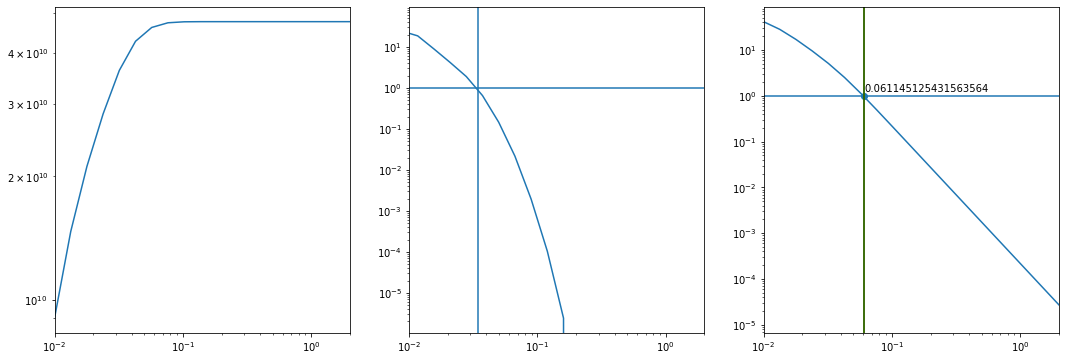

0.06473082037010398 0.08360306936514639 5000
0.07421427870041895


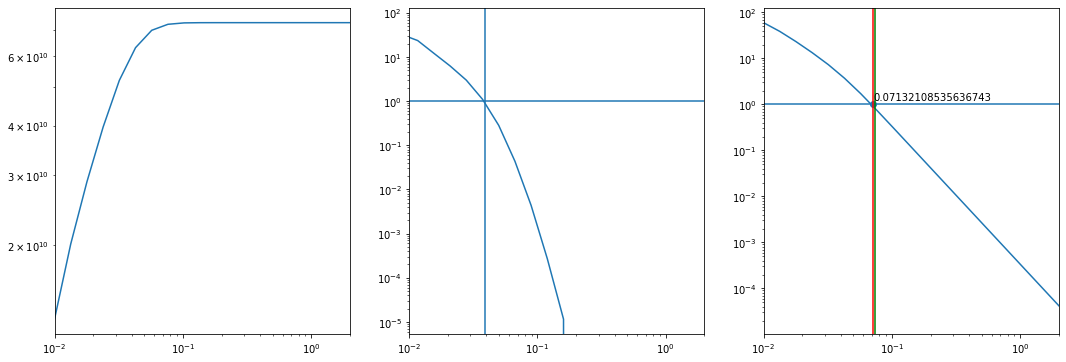

0.08360306936514639 0.10797751623277094 5000
0.0948419757256351


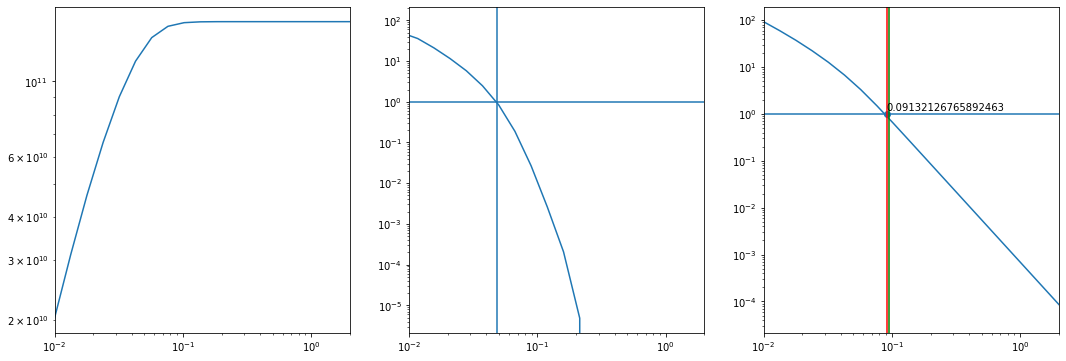

0.10797751623277094 0.1394583249195745 5000
0.12150917741748754


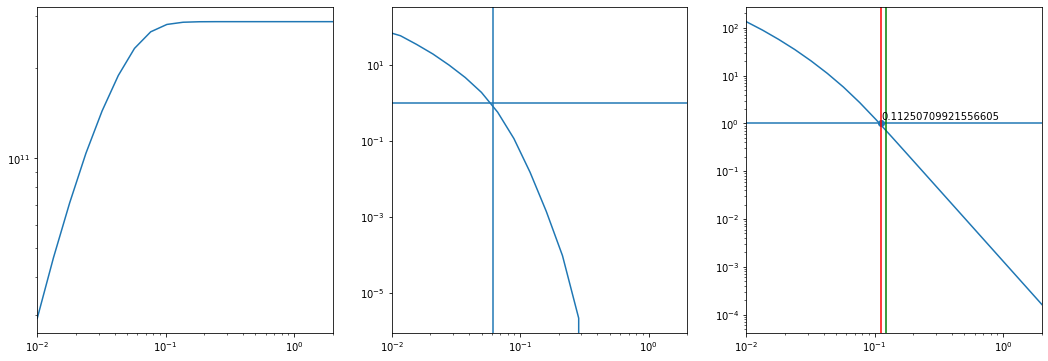

0.1394583249195745 0.1801173528334133 5000
0.15648103839399669


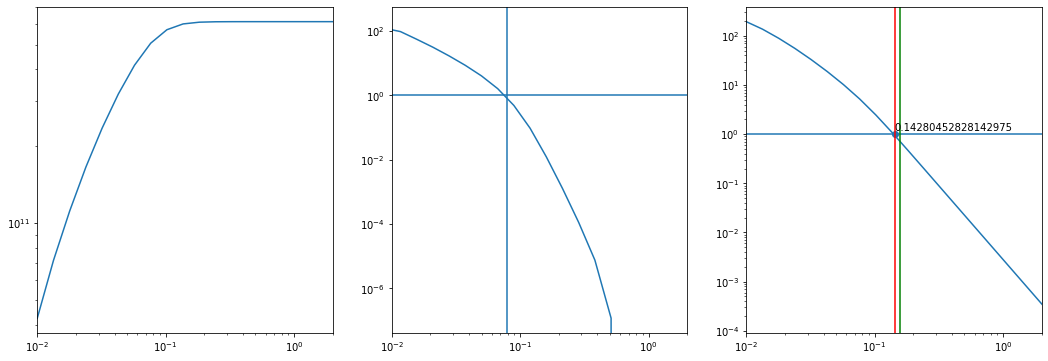

0.1801173528334133 0.23263050671536256 5000
0.2021541205532228
noisy data


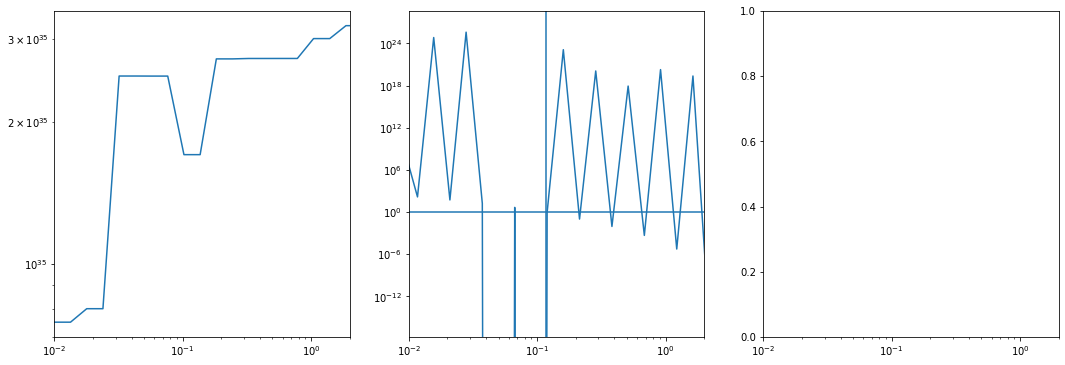

In [41]:
for j in range(len(radbins)-1):
    try:
        select_rad_ind = np.where(np.all((halvirrad>radbins[j], halvirrad<radbins[j+1], halprop.root.hostHaloID[:]==-1, abs(kin_ratio-1) < 0.5), axis=0))[0][:5000]
        print(radbins[j], radbins[j+1], len(select_rad_ind))
        mass_profile_mean = radprof.root.Mass_profile[:][select_rad_ind].mean(axis=0)*h**2/a**3
        r_vir_vr_mean = halprop.root.R_BN98[:][select_rad_ind].mean(axis=0)
        print(r_vir_vr_mean)
        fig, (ax1,ax2, ax3) = plt.subplots(1,3, figsize=(18,6), sharex=True)
        ax1.loglog(Rad_bin_edge[1:], np.cumsum(mass_profile_mean))
        ax1.set_xlim(1e-2,2)
        rhor = mass_profile_mean/ (4/3*np.pi* (Rad_bin_edge[1:]**3-Rad_bin_edge[:-1]**3) )/ vir_dens
        r_rho_is_vir = interp1d(rhor, Rad_bin_cen)(1)
        ax2.loglog(Rad_bin_cen, rhor,)
        ax2.axhline(1)
        ax2.axvline(r_rho_is_vir)
        rhoR = np.cumsum(mass_profile_mean)/ (4/3*np.pi* (Rad_bin_edge[1:]**3))/ vir_dens
        r_vir = interp1d(rhoR, Rad_bin_edge[1:])(1)
    #     idx_vir = np.argwhere(np.diff(np.sign(rhoR-1))).flatten()
        ax3.loglog(Rad_bin_edge[1:], rhoR ,)
        ax3.axhline(1)
        ax3.axvline(r_vir,color='red')
        ax3.axvline(r_vir_vr_mean, color='green')
        ax3.scatter(r_vir,1)
        ax3.annotate(f'{r_vir}', (r_vir,1.2))
    #     plt.ylim(0, 3)
        plt.show()
        sleep(.01)
        plt.close()
    except:
        print('noisy data')
        break
    

In [ ]:
select_rad_ind = np.where(np.all((halvirrad>8e-2, halvirrad<5e-1, halprop.root.hostHaloID[:]==-1), axis=0))[0]
select_mass_ind = np.where(np.all((halvirmass>5e1, halvirmass<6e1, halprop.root.hostHaloID[:]==-1), axis=0))[0]
plt.plot(radprof.root.Radial_bin_edges[1:], radprof.root.Mass_profile[:][select_mass_ind][0:10].mean(axis=0))

In [ ]:
radprof.root.Mass_profile[:][select_mass_ind]

In [ ]:
plt.hist(halprop.root.Rvir, bins=np.logspace(-2,0))
plt.xscale('log')

In [ ]:
# halprop.root

In [ ]:
# pd.read_hdf(f"/scratch/cprem/sims/bdm_cdm1024/r1/halos_vr_6d/out_{i:03d}.profiles.0",'Mass_profile')

In [ ]:
radprof.close()
halprop.close()

In [28]:
def Omega(z, Om0):
    E = Om0 * (1+z)**3 + (1-Om0)
    return Om0 * (1+z)**3 / E

In [29]:
Omega(z=1.2,Om0=0.3)

0.8202547247329499

In [30]:
0.8202547247329499*200

164.05094494659

In [31]:
rad_bin_edge_input = np.array([-2.,-1.87379263,-1.74758526,-1.62137789,-1.49517052,-1.36896316,-1.24275579,-1.11654842,-0.99034105,-0.86413368,-0.73792631,-0.61171894,-0.48551157,-0.3593042,-0.23309684,-0.10688947,0.0193179,0.14552527,0.27173264,0.39794001,
])

In [33]:
radprof.root.Radial_bin_edges[:]

array([0.        , 0.01      , 0.01337234, 0.01788194, 0.02391234,
       0.0319764 , 0.04275992, 0.05718001, 0.07646304, 0.10224897,
       0.1367308 , 0.18284105, 0.24450123, 0.32695534, 0.43721576,
       0.5846597 , 0.78182676, 1.04548523, 1.39805828, 1.86953082,
       2.50000001])

In [35]:
10**rad_bin_edge_input

array([0.01      , 0.01337234, 0.01788194, 0.02391234, 0.03197639,
       0.04275992, 0.05718001, 0.07646304, 0.10224897, 0.13673079,
       0.18284104, 0.24450124, 0.32695534, 0.43721575, 0.5846597 ,
       0.78182676, 1.04548523, 1.39805826, 1.86953087, 2.50000001])

In [36]:
rad_bin_edge_input[1:]-rad_bin_edge_input[:-1]

array([0.12620737, 0.12620737, 0.12620737, 0.12620737, 0.12620736,
       0.12620737, 0.12620737, 0.12620737, 0.12620737, 0.12620737,
       0.12620737, 0.12620737, 0.12620737, 0.12620736, 0.12620737,
       0.12620737, 0.12620737, 0.12620737, 0.12620737])

In [38]:
radprof.root.Mass_profile[:][select_mass_ind][0:10].mean(axis=0).sum()

56.08415

In [41]:
for j in range(len(massbins)-1):
    select_mass_ind = np.where(np.logical_and(halvirmass>massbins[j], halvirmass<massbins[j+1], halprop.root.hostHaloID[:]==-1))[0]
    print(radprof.root.Mass_profile[:][select_mass_ind][0:10].mean(axis=0).sum())

15.668254
22.036436
34.835854
53.120735
83.196236
148.58047
217.74777
350.25037
576.16315
788.6141
1280.5109
1490.1583
1139.1132
550.5258
722.24243


In [44]:
halprop.root.Xc[:].max()

149.99952083191604

In [45]:
halprop.close()